# Vaccinations

Comorbuss comes with a fexible vaccination mechanic. Multiple vaccination campaings can be set with the `vaccinations` paremeter, where a list of dictionaries can be stored with the parameters for each vaccination campaing.

## Using predefined vaccination campaings

In the `vaccination` module inside Comorbuss there is already a number of pre configured dictionaries for vaccinations campaing, the user can test vaccination by only loading those predefined configurations:

[Progress] Initialization took 1.33 seconds [step: 0, day: 0, hour: 0.0]
[Progress] Initialization OK, starting simulation [step: 0, day: 0, hour: 0.0]
[Progress] Simulation took 92.58 seconds [step: 1439, day: 59, hour: 23.0]
[Results] Number of infections: 886
[Results] Number of asymptomatic cases: 532
[Results] Number of light symptomatic cases: 288
[Results] Number of severe symptomatic: 64
[Results] Number of deaths: 8
[Results] Infections at home: 519
[Results] Infections on environment: 54
[Results] Infections on Markets: 147
[Results] Infections on Hospitals: 3
[Results] Infections on Schools: 119
[Results] Infections on Restaurants: 34
[Results] Total number vaccinated: 240
[Results] Not diagnosed vaccination: 240
[Results] Number immune on the last day: 120



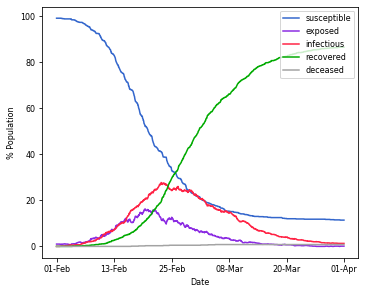

In [1]:
from comorbuss import community, vaccination, diagnostics, Analysis

parameters = {
    "vaccinations": [vaccination.DIAG_NO],
    "diagnostics": [diagnostics.PCR],
}

comm = community(**parameters)
comm.simulate()

analysis = Analysis.from_comm(comm)
analysis.plot_SEIR()
analysis.close()


In the example above a vaccination campaing will be ran from the first day of simulation of all particles with no diagnostics or a negative diagnostic, all the others parameters will be set to the default values.

Default values for vaccinations are:

In [2]:
from comorbuss import vaccination
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(vaccination.DEFAULTS)

{   'days_to_immunity': 30,
    'doses_per_day': 1000,
    'effectiveness': 1.0,
    'filter': ('diag_states', '!=', 1),
    'name': 'Vaccination',
    'start_day': 0}


* `name`: Name for identifications of the vaccination campaing.
* `days_to_immunity`: Number of days fom the inoculation of one particle for it to develop immunity.
* `doses_per_day`: Number of doses per days to be applied in the selected population (this is normalized with the number of particles).
* `filter`: Filter to select the target population (see Creating custom filters below).
* `effectiveness`: Fraction of the inoculated particles that develop immunity.
* `start_day`: Number of days from the start of the simulation to start the vaccination campaing.

Available predefined vaccination campaings can be found in the [documentation](http://comorbuss.nngn.net/0.2.0-dev/interventions/vaccination/#predefined-vaccinations). 

## Customizing predefined campaings

The user easily load a predefined campaing but change one or more parameter, this can be done by placing the predefined dictionary inside a tuple along with a custom dictionary with the parameters to be replaced. For exapmle if the user wishes to increase the number of doses per day from 1000 to 10000 in the example above:

[Progress] Initialization took 1.24 seconds [step: 0, day: 0, hour: 0.0]
[Progress] Initialization OK, starting simulation [step: 0, day: 0, hour: 0.0]
[Progress] Simulation took 104.62 seconds [step: 1439, day: 59, hour: 23.0]
[Results] Number of infections: 858
[Results] Number of asymptomatic cases: 519
[Results] Number of light symptomatic cases: 274
[Results] Number of severe symptomatic: 64
[Results] Number of deaths: 10
[Results] Infections at home: 493
[Results] Infections on environment: 54
[Results] Infections on Markets: 144
[Results] Infections on Hospitals: 3
[Results] Infections on Schools: 120
[Results] Infections on Restaurants: 34
[Results] Total number vaccinated: 981
[Results] Not diagnosed vaccination: 981
[Results] Number immune on the last day: 981



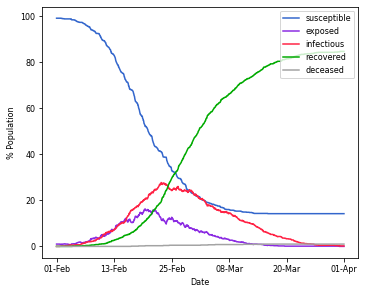

In [3]:
from comorbuss import community, vaccination, diagnostics, Analysis

parameters = {
    "vaccinations": [(vaccination.DIAG_NO, {"doses_per_day": 10000})],
    "diagnostics": [diagnostics.PCR],
}

comm = community(**parameters)
comm.simulate()

analysis = Analysis.from_comm(comm)
analysis.plot_SEIR()
analysis.close()

We can see that the number of inoculated particles increased and the number of infections decreased.

## Creating custom filters

New vaccination campaings can be created by creating custom filters to select particles to vaccinate.

Filters are a sequence of nested tuples of strings and values to be evaluated to select particles to vaccinate, strings can be population attributes (see [particles states attributes](http://comorbuss.nngn.net/0.2.0-dev/reference/population/#particles-states-attributes)), comparative operators, binary operators or makers (see markers bellow). Examples:

* `("diag_states", "!=", DIAG_YES)` equivalent as `population.diag_states != DIAG_YES`, and will select all particles with a dianostins states diferent than `DIAG_YES` that is a positive disgnostic.
* `((("symptoms", "==", SYMPT_YES), "|", ("symptoms", "==", SYMPT_SEVERE)), "&", ("diag_states", "!=", DIAG_YES))` is equivalent as `((population.symptoms == SYMPT_YES) | (population.symptoms == SYMPT_SEVERE)) & (population.diag_states != DIAG_YES)`, and will select all sympomatic particles (severe or mild) that has a a dianostins states diferent than `DIAG_YES`.
* `(("diag_states", "!=", DIAG_YES), "&", ("ages", "isin", list(range(12, 22))))` is equivalent as `((population.diag_states != DIAG_YES) & (np.isin(population.ages, list(range(12, 22)))))`, and will select  all particles with a dianostins states diferent than `DIAG_YES` in age groups from 12 to 21 (60+ years old).
* `("workplace_id", "==", ("service", "Markets"))`  is equivalent as `(population.workplace_id == services["Markets"].id)`, and will select all Markets workers.
* `(("workplace_id", "==", ("service", "SCHOOLS")), "&", ("worker_type", "==", ("workers", "Schools", "Teachers")))`  is equivalent as `(population.workplace_id == services["Schools"].id) & (population.worker_type == services["Schools"].workers_parameters["Teachers"].id)`, and will select all school's teachers.

Available markers for filter_in:

* `("service", service_name)` will load the id of the service with the name `service_name`.
* `("workers", service_name, workers_name)` will load the id of the worker type with the name `workers_name` of the service with the name `service_name`.
* `("tracing", trace_filters, number_of_days)` will select all particles that had tracable contact with particles selected by trace_filters in the last number_of_days days.

**ATTENTION:** Do NOT use python's normal boolean operators (`and`, `or`, `not`, etc), all operations are applied on numpy boolean arrays and the apropriate operators to use are binary operators (`&`, `|`, `~`, etc).

Let`s now create a custom vaccination campaing that applies 500 doses per day in all not diagnosed schools workers (students and teachers):

[Progress] Initialization took 1.09 seconds [step: 0, day: 0, hour: 0.0]
[Progress] Initialization OK, starting simulation [step: 0, day: 0, hour: 0.0]
[Progress] 100% |████████████████████████| 60.0/60.0 days [ 1.03s/day, 0.0s rem]
[Progress] Simulation took 61.58 seconds [step: 1439, day: 59, hour: 23.0]
[Results] Number of infections: 885
[Results] Number of asymptomatic cases: 536
[Results] Number of light symptomatic cases: 285
[Results] Number of severe symptomatic: 64
[Results] Number of deaths: 8
[Results] Infections at home: 518
[Results] Infections on environment: 53
[Results] Infections on Markets: 146
[Results] Infections on Hospitals: 3
[Results] Infections on Schools: 119
[Results] Infections on Restaurants: 36
[Results] Total number vaccinated: 120
[Results] Schools vaccination: 120
[Results] Number immune on the last day: 60


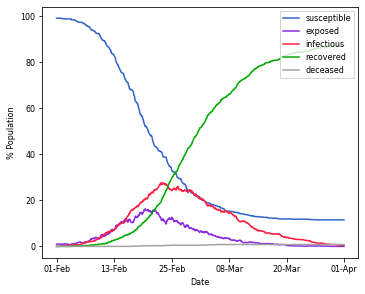

In [4]:
from comorbuss import community, vaccination, diagnostics, Analysis

schools_vaccination = {
    "name": "Schools",
    "doses_per_day": 500,
    "filter": (("workplace_id", "==", ("service", "Schools")), "&", vaccination.FILTER_DIAG_NO)
}

parameters = {
    "vaccinations": [schools_vaccination],
    "diagnostics": [diagnostics.PCR],
}

comm = community(**parameters)
comm.simulate()

analysis = Analysis.from_comm(comm)
analysis.plot_SEIR()
analysis.close()